In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import _reverser, revcmap, _reverse_cmap_spec, ScalarMappable
import cmocean
import os
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
%matplotlib inline

In [2]:
import glob

In [3]:
dir_glob = r'R:\pr\3286_30\temp\out//ET_NL_100m_final_*_1.tif'

In [4]:
list_tifs = glob.glob(dir_glob)

In [5]:
def cpt2python(cptfile):
    """
    Convert GMT-stype CPT file to python colormap.  This routine is modified from a 
    routine contained in the scipy cookbook. 
    """
    fid = open(cptfile,'r')
    reads = fid.readlines()
    fid.close()

    x = np.empty(len(reads),dtype=np.float32)
    r,g,b = np.empty_like(x),np.empty_like(x),np.empty_like(x)
    colormod = 'RGB'
    i = 0
    for read in reads:
        if len(read.lstrip()) > 0:
            row = read.split()
            if read.lstrip()[0] == '#':
                if 'COLOR_MODEL' in read: colormod = row[-1]
            elif 'B' != row[0] and 'F' != row[0] and 'N' != row[0]:
                if '/' not in row[1] and '-' not in row[1]:
                    x[i] = np.float32(row[0])
                    r[i] = np.float32(row[1])
                    g[i] = np.float32(row[2])
                    b[i] = np.float32(row[3])
                    xt = np.float32(row[4])
                    rt = np.float32(row[5])
                    gt = np.float32(row[6])
                    bt = np.float32(row[7])
                elif len(row) == 4:
                    if '-' in row[1]:
                        spl = '-'
                        colormod = 'HSV'
                    else:
                        spl = '/'
                    x[i] = np.float32(row[0])
                    rs = _stitch_gmt_hsv(row[1],splitter=spl)
                    r[i] = np.float32(rs[0])
                    g[i] = np.float32(rs[1])
                    b[i] = np.float32(rs[2])
                    xt = np.float32(row[2])
                    rs = _stitch_gmt_hsv(row[3],splitter=spl)
                    rt = np.float32(rs[0])
                    gt = np.float32(rs[1])
                    bt = np.float32(rs[2])
                else:
                    raise cptError('Unsupported cpt format...revise file to form x1 r1 g1 b1 x2 r2 g2 b2')
                i += 1
    x[i], r[i], g[i], b[i] = xt, rt, gt, bt
    i += 1
    x, r, g, b = x[:i], r[:i], g[:i], b[:i]

    if colormod == 'HSV' or colormod == 'hsv':
        import colorsys
        for i in range(len(r)):
            r[i], g[i], b[i] = colorsys.hsv_to_rgb(r[i]/360.,g[i],b[i])
    elif colormod == 'RGB' or colormod == 'rgb':
        r /= 255.; g /= 255.; b /= 255.
    else:
        raise NotImplementedError('%s color system is not supported' % colormod)

    x -= x[0]
    x /= x[-1]

    red, blue, green = [None]*len(x), [None]*len(x), [None]*len(x)
    for i in range(len(x)):
        red[i] = (x[i],r[i],r[i])
        blue[i] = (x[i],b[i],b[i])
        green[i] = (x[i],g[i],g[i])
    cd = {'red' : red, 'green' : green, 'blue' : blue}
    return cd

def cpt2cmap(filename,cmapname='colormap',lut=None,inverse=False):
    if not lut:
        import matplotlib as mpl 
        lut = mpl.rcParams['image.lut']
    cdict = cpt2python(filename)
    if inverse: cdict = _reverse_cmap_spec(cdict)
    return matplotlib.colors.LinearSegmentedColormap(cmapname,cdict,lut)

In [6]:
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    
    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1) ]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [7]:
# get from http://soliton.vm.bytemark.co.uk/pub/cpt-city/index.html
nrwc_path = r'D:\Projects\Pr\3492.10\ET//nrwc.cpt'
cpt_cm = cpt2cmap(nrwc_path, 'nrwc', inverse=True)

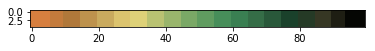

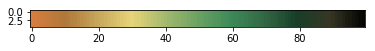

In [8]:
cmap_cont = cpt_cm#cmocean.cm.speed_r
x = np.resize(np.arange(100), (5,100))
cmap_disc = cmap_discretize(cmap_cont, 20)

# plot as discrete
plt.imshow(x, cmap=cmap_disc)
plt.show()
# plot as continous
plt.imshow(x, cmap=cmap_cont)
plt.show()

In [9]:
from osgeo import gdal, osr
import cartopy.crs as ccrs
from copy import copy
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import shapely.geometry as sgeom

c:\python35\lib\site-packages\matplotlib\ticker.py:1693: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


In [10]:
def setMap(rasterBase):

    # Read the data and metadata
    ds = gdal.Open(rasterBase)
    #band = ds.GetRasterBand(20)
    
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    proj = ds.GetProjection()
    
    nan = ds.GetRasterBand(1).GetNoDataValue()
    if nan != None:
        data = np.ma.masked_equal(data,value=nan)
    
    xres = gt[1]
    yres = gt[5]
    
    # get the edge coordinates and add half the resolution 
    # to go to center coordinates
    xmin = gt[0] + xres * 0.5
    xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
    ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
    ymax = gt[3] - yres * 0.5
    
    x = ds.RasterXSize 
    y = ds.RasterYSize  
    extent = [ gt[0],gt[0]+x*gt[1], gt[3],gt[3]+y*gt[5]]
    #ds = None
    img_extent = (extent[0], extent[1], extent[2], extent[3])
    
    # create a grid of xy coordinates in the original projection
    #xy_source = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
    
    return extent, img_extent, proj, data#, xy_source

In [11]:
#as function
def plot_colors_labels(ax, cb, im, im_title, cb_label, fg_color='white', bg_color='black'):    
    # IMSHOW    
    # set title plus title color
    ax.set_title(im_title, color=fg_color, fontsize=24)
    
    # set options for figure while using cartopy
    try:
        ax.background_patch.set_fill(False)
        ax.outline_patch.set_edgecolor(bg_color) # change to fg_color for white frame!
    except:
        pass
    ax.patch.set_facecolor(bg_color)
    
    # set tick and ticklabel color
    im.axes.tick_params(color=fg_color, labelcolor=fg_color)
    
    # set imshow outline
    for spine in im.axes.spines.values():
        spine.set_edgecolor(fg_color)    

    # COLORBAR
    # set colorbar label plus label color
    cb.set_label(cb_label, color=fg_color)
    
    # set colorbar tick color
    cb.ax.yaxis.set_tick_params(color=fg_color)
    
    # set colorbar edgecolor 
    cb.outline.set_edgecolor(fg_color)
    
    # set colorbar ticklabels
    plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=fg_color)

In [12]:
ET_data     = r'D:\Projects\Pr\3492.10\ET\ET_NL_100m_final_20160824_1.tif'
ET_data_png = r'D:\Projects\Pr\3492.10\ET\ET_NL_100m_final_20160824_1.png'
extent, img_extent, proj, data = setMap(ET_data)

In [13]:
vmin_ = np.round(data.mean() - (data.std() * 3),1)
vmax_ = np.round(data.mean() + (data.std() * 3),1)
print (vmin_,vmax_)

0.8 5.3


In [14]:
# check if mask is applied
if np.ma.is_masked(data[0][0]) is False:
    print ('nan nog niet gezet')
    nan = data[0][0]
    data = np.ma.masked_where(data == nan, data)
else:
    print ('nan al gezet')

nan al gezet


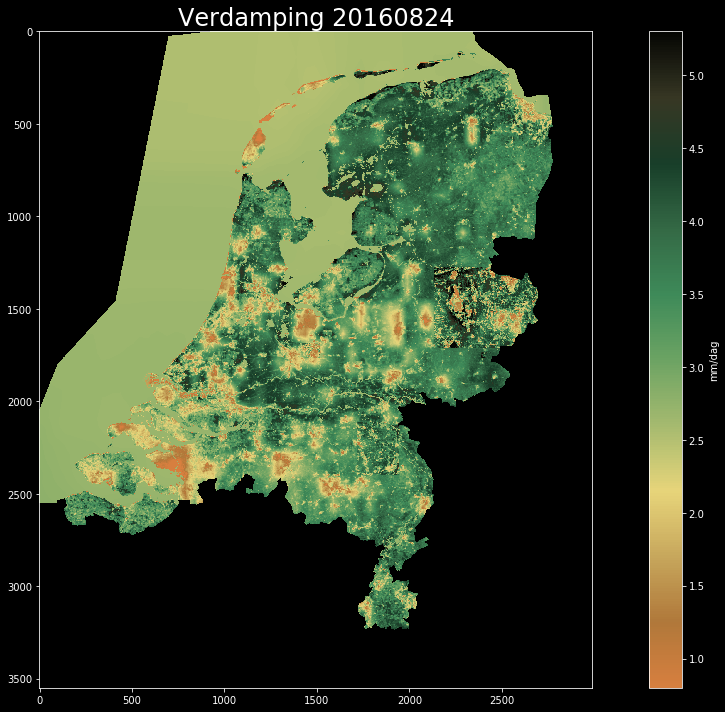

In [15]:
fig, ax1 = plt.subplots(1,1, figsize=(16,10))
im = ax1.imshow(data, interpolation='nearest', cmap=cmap_cont, vmin=vmin_, vmax=vmax_)
cb = fig.colorbar(im,ax=ax1, format='%.1f')
plot_colors_labels(ax1, cb, im, 'Verdamping 20160824', 'mm/dag')

fig.patch.set_facecolor('black') 
plt.tight_layout()

plt.show()

In [16]:
# plot the same image in LCC projection inclusive gridlines, shapefile geometry outlining provinces

In [17]:
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])


def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])
    

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

In [18]:
from pathlib import Path

In [19]:
base_png = r'C:\Projects\Pr\3492.10\BruinKeijman\png\FINAL_PNG'
for file_in in list_tifs:
    
    ET_data_png = os.path.join(base_png,'ET_'+file_in[-14:-4]+'.png')
    print (ET_data_png)
    my_file = Path(ET_data_png)
    if my_file.is_file():
        print ('file exist')
        continue
        # file exists    
        
    data = gdal.Open(file_in).ReadAsArray()
    
    # check if mask is applied
    if np.ma.is_masked(data[0][0]) is False:
        print ('nan nog niet gezet')
        nan = data[0][0]
        data = np.ma.masked_where(data == nan, data)
    else:
        print ('nan al gezet') 

    
    print (ET_data_png)
    # Create a Lambert Conformal Connic projection using long/lat van onze lieve vrouwe kerke in Amersfoort:
    proj = ccrs.LambertConformal(central_longitude=5.38724, central_latitude=52.15519,
                                 false_easting=400000, false_northing=400000,
                                 standard_parallels=(46, 49))

    # Create figure, add axes in LCC projection and set extent using 28992 bounding box coordinates:
    #fig = plt.figure(figsize=(16, 10), frameon=True)
    fig = Figure(figsize=(16, 10), frameon=True)
    canvas = FigureCanvas(fig)

    ax1 = fig.add_axes([0.08, 0.05, 0.8, 0.94], projection=proj)
    ax1.set_extent(extent, crs=ccrs.epsg(28992))

    # add the figure using gdal data in 28992 projection and add discrete cmocean.speed colorbar
    im = ax1.imshow(data, 
                    #origin    = 'upper', 
                    extent    = img_extent,
                    transform = ccrs.epsg(28992), 
                    vmin      = 0,
                    vmax      = 10,
                    cmap      = cmap_cont)
    cb = fig.colorbar(im,ax=ax1, format='%.1f')

    # add white coastlines
    ax1.coastlines(resolution='10m', color='white')

    # *must* call draw in order to get the axis boundary used to add ticks:
    fig.canvas.draw()

    # Define gridline locations and draw the lines using cartopy's built-in gridliner:
    xticks = [1,3, 5, 7, 9,11]
    yticks = [50,51, 52, 53,54]
    ax1.gridlines(xlocs=xticks, ylocs=yticks)

    # Label the end-points of the gridlines using the custom tick makers:
    ax1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
    ax1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    lambert_xticks(ax1, xticks)
    lambert_yticks(ax1, yticks)


    ax1.text(3.4, 50.7, file_in[-14:-4], color='white', fontsize=25, transform=ccrs.Geodetic())

    # invert colour scheme and plot as black
    plot_colors_labels(ax1, cb, im, 'Verdamping ', 'mm/dag')

    fig.patch.set_facecolor('black') 
    #plt.tight_layout()
    #plt.show()
    fig.savefig(ET_data_png, facecolor=fig.get_facecolor(), dpi=200, edgecolor='none', bbox_inches='tight')
    #plt.close(fig)    

C:\Projects\Pr\3492.10\BruinKeijman\png\FINAL_PNG\ET_20151010_1.png
file exist
C:\Projects\Pr\3492.10\BruinKeijman\png\FINAL_PNG\ET_20150701_1.png
file exist
C:\Projects\Pr\3492.10\BruinKeijman\png\FINAL_PNG\ET_20160602_1.png
file exist
C:\Projects\Pr\3492.10\BruinKeijman\png\FINAL_PNG\ET_20160603_1.png
file exist
C:\Projects\Pr\3492.10\BruinKeijman\png\FINAL_PNG\ET_20160403_1.png
file exist
C:\Projects\Pr\3492.10\BruinKeijman\png\FINAL_PNG\ET_20150628_1.png
file exist
C:\Projects\Pr\3492.10\BruinKeijman\png\FINAL_PNG\ET_20150629_1.png
file exist
C:\Projects\Pr\3492.10\BruinKeijman\png\FINAL_PNG\ET_20150630_1.png
file exist
C:\Projects\Pr\3492.10\BruinKeijman\png\FINAL_PNG\ET_20150902_1.png
file exist
C:\Projects\Pr\3492.10\BruinKeijman\png\FINAL_PNG\ET_20150702_1.png
file exist
C:\Projects\Pr\3492.10\BruinKeijman\png\FINAL_PNG\ET_20160426_1.png
file exist
C:\Projects\Pr\3492.10\BruinKeijman\png\FINAL_PNG\ET_20160509_1.png
file exist
C:\Projects\Pr\3492.10\BruinKeijman\png\FINAL_PNG\ET

In [ ]:
# # Create a Lambert Conformal Connic projection using long/lat van onze lieve vrouwe kerke in Amersfoort:
# proj = ccrs.LambertConformal(central_longitude=5.38724, central_latitude=52.15519,
#                              false_easting=400000, false_northing=400000,
#                              standard_parallels=(46, 49))

# # Create figure, add axes in LCC projection and set extent using 28992 bounding box coordinates:
# #fig = plt.figure(figsize=(16, 10), frameon=True)
# fig = Figure(figsize=(16, 10), frameon=True)
# canvas = FigureCanvas(fig)

# ax1 = fig.add_axes([0.08, 0.05, 0.8, 0.94], projection=proj)
# ax1.set_extent(extent, crs=ccrs.epsg(28992))

# # add the figure using gdal data in 28992 projection and add discrete cmocean.speed colorbar
# im = ax1.imshow(data, 
#                 #origin    = 'upper', 
#                 extent    = img_extent,
#                 transform = ccrs.epsg(28992), 
#                 vmin      = 0,
#                 vmax      = 16,
#                 cmap      = cmap_cont)
# cb = fig.colorbar(im,ax=ax1, format='%.1f')

# # add white coastlines
# ax1.coastlines(resolution='10m', color='white')

# # *must* call draw in order to get the axis boundary used to add ticks:
# fig.canvas.draw()

# # Define gridline locations and draw the lines using cartopy's built-in gridliner:
# xticks = [1,3, 5, 7, 9,11]
# yticks = [50,51, 52, 53,54]
# ax1.gridlines(xlocs=xticks, ylocs=yticks)

# # Label the end-points of the gridlines using the custom tick makers:
# ax1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
# ax1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
# lambert_xticks(ax1, xticks)
# lambert_yticks(ax1, yticks)


# ax1.text(3.4, 50.7, r'2016-08-24', color='white', fontsize=25, transform=ccrs.Geodetic())
    
# # invert colour scheme and plot as black
# plot_colors_labels(ax1, cb, im, 'Verdamping ', 'mm/dag')

# fig.patch.set_facecolor('black') 
# #plt.tight_layout()
# #plt.show()
# fig.savefig(ET_data_png, facecolor=fig.get_facecolor(), dpi=200, edgecolor='none', bbox_inches='tight')
# #plt.close(fig)